In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
from sklearn import preprocessing, model_selection
from sklearn import cluster, manifold
from sklearn import metrics
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("data/CC GENERAL.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [4]:
df.fillna(df.mean(numeric_only=True), inplace=True)
df['MINIMUM_PAYMENTS'].mean()

864.2065423050827

In [5]:
ss = preprocessing.StandardScaler()
X_norm = ss.fit_transform(df.iloc[:,1:])
X_norm

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

<Axes: title={'center': 'silhouette score'}, xlabel='n_clusters', ylabel='score'>

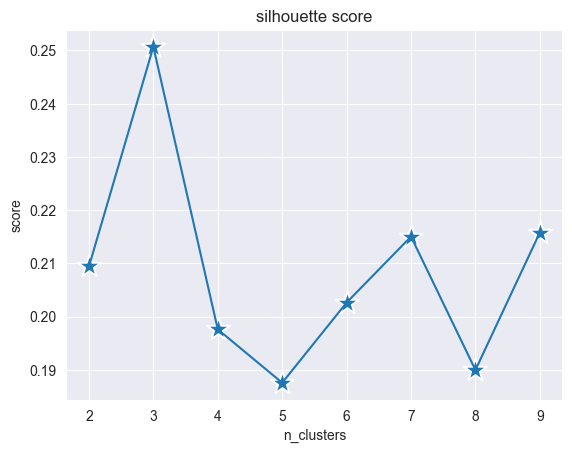

In [6]:
def get_silhoutte(n, data):
    estimator = cluster.KMeans(n, random_state=42, n_init=5)
    preds = estimator.fit_predict(data)
    return metrics.silhouette_score(data, preds)
scores = list()
for n in range(2,10):
    scores.append(get_silhoutte(n, X_norm))
sns.lineplot(x=range(2,10), y=scores).set(title='silhouette score', xlabel='n_clusters', ylabel='score')
sns.scatterplot(x=range(2,10), y=scores, s=300, marker='*')
    

### optimal clusters: 3

In [7]:
opt_kmeans = cluster.KMeans(3, n_init=10, random_state=42)
preds = opt_kmeans.fit_predict(X_norm)
pd.value_counts(preds)

2    6119
0    1596
1    1235
Name: count, dtype: int64

In [8]:
dbscan = cluster.DBSCAN() # default
preds = dbscan.fit_predict(X_norm)

In [9]:
np.unique(dbscan.labels_)


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37], dtype=int64)

In [41]:
db_params = {
    'eps': np.arange(0.1,3,0.2),
    'min_samples': np.arange(1,20,4)
}
scores = []
for eps in db_params['eps']:
    for mins in db_params['min_samples']:
        est = cluster.DBSCAN(eps=eps, min_samples=mins)
        labels = est.fit_predict(X_norm)
        scores.append({'params': [eps,mins], 'score': metrics.silhouette_score(X_norm,labels)})
print('Best dbscan params: {}'.format(max(scores, key= lambda dct: dct['score'])))

Best dbscan params: {'params': [2.900000000000001, 5], 'score': 0.6173453608696496}


In [10]:
est = cluster.AgglomerativeClustering(3)
labels = est.fit_predict(X_norm)
score = metrics.silhouette_score(X_norm, labels)
score

0.1731098007232828

In [11]:
max_scr = 0
optimal = 3
for n_cl in range(3,10):
    est = cluster.AgglomerativeClustering(n_cl)
    labels = est.fit_predict(X_norm)
    score = metrics.silhouette_score(X_norm, labels)
    if score > max_scr:
        max_scr = score
        optimal = n_cl
print(optimal)
    

6


In [13]:
max_scr

(0.17335577924064002,)

In [15]:
agg_clst = cluster.AgglomerativeClustering(optimal)
agg_clst.fit_predict(X_norm)
np.unique(agg_clst.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int64),
 array([3946, 2931,  864,  464,   23,  722], dtype=int64))

c:\Users\mblyz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


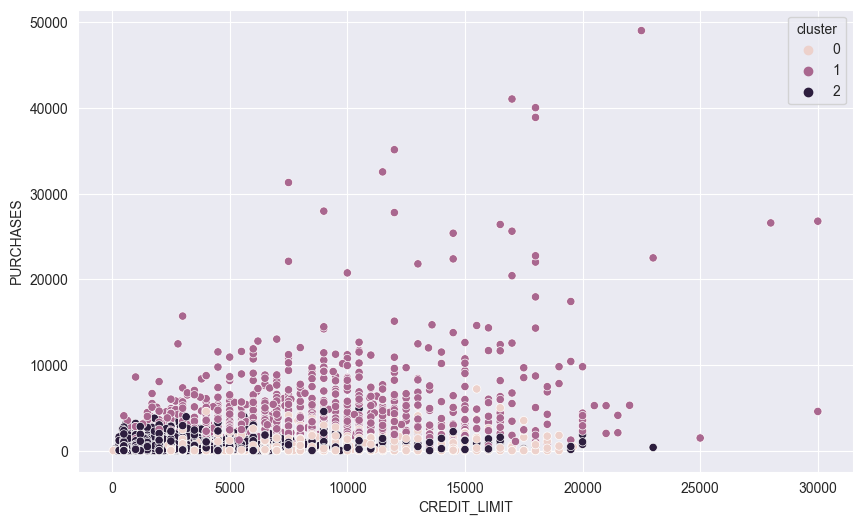

In [12]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)
df['cluster'] = kmeans.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.show()